In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

### Read_dataset

In [6]:
df = pd.read_csv('C:/Users/giryi/Portfolio/dataset/monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [11]:
#### Data Preprocessing

In [12]:
# cek missing value
pd.isnull(df).sum()

Monthly beer production    0
dtype: int64

In [52]:
# bagi data train sama test
# data test untuk data 2 tahun ke depan
split_data = len(df) - 24
train_data = df[:split_data]
test_data = df[split_data:]

print('train_data : ',len(train_data))
print('test_data : ',len(test_data))

train_data :  452
test_data :  24


#### Identifikasi Model 

Untuk mencari tahu data ini pola nya sudah stasioner atau belum

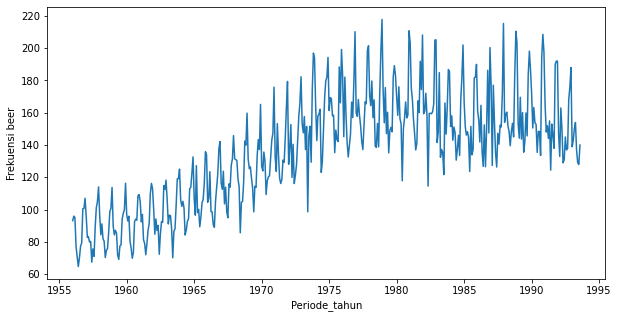

In [37]:
plt.figure(figsize=(10,5))
plt.xlabel('Periode_tahun')
plt.ylabel('Frekuensi beer')
plt.plot(train_data)

Terlihat bahwa pola data tidak stasioner, maka dilakukan proses diferensiasi

#### Cek stationary

In [38]:
def cek_stationary(sales):
    result = adfuller(sales)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('lags-used: {}'.format(result[2]))
    print('number of Observations: {}'.format(result[3]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

cek_stationary(train_data['Monthly beer production'])

ADF Statistic: -2.1939328637496964
p-value: 0.20845484216736537
lags-used: 17
number of Observations: 434
Critical Values:
	1%: -3.44550760169756
	5%: -2.868222645936761
	10%: -2.5703296137102085


Pengujian stationary menggunakan hypothesis testing, dimana menggunakan alpha=0.05 , jika p-value < Alpha H0 ditolak, berikut hasil analisisnya :

H0 : data stasioner
H1 : data tidak stasioner

Dari hasil ini didapat p-value sebesar 0.17 lebih dari alppha,maka dari H0 ditolak dan dilakukan tahap diferensiasi

#### Diferensiasi

In [39]:
train_data['diferensiasi_pertama'] = train_data['Monthly beer production'] - train_data['Monthly beer production'].shift(1)
train_data.head()

C:\Users\giryi\AppData\Local\Temp/ipykernel_22060/1244048210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['diferensiasi_pertama'] = train_data['Monthly beer production'] - train_data['Monthly beer production'].shift(1)


,Monthly beer production,diferensiasi_pertama
Month,,
1956-01-01,93.2,NaN
1956-02-01,96.0,2.8
1956-03-01,95.2,-0.8
1956-04-01,77.1,-18.1
1956-05-01,70.9,-6.2


In [40]:
stat_data=train_data[1:]
stat_data.head()

,Monthly beer production,diferensiasi_pertama
Month,,
1956-02-01,96.0,2.8
1956-03-01,95.2,-0.8
1956-04-01,77.1,-18.1
1956-05-01,70.9,-6.2
1956-06-01,64.8,-6.1


In [41]:
cek_stationary(stat_data['diferensiasi_pertama'])

ADF Statistic: -4.788464904743391
p-value: 5.721767263739899e-05
lags-used: 18
number of Observations: 432
Critical Values:
	1%: -3.445578199334947
	5%: -2.8682536932290876
	10%: -2.570346162765775


didapat hasil 2.553-05 kurang dari alpha , maka H0 diterima

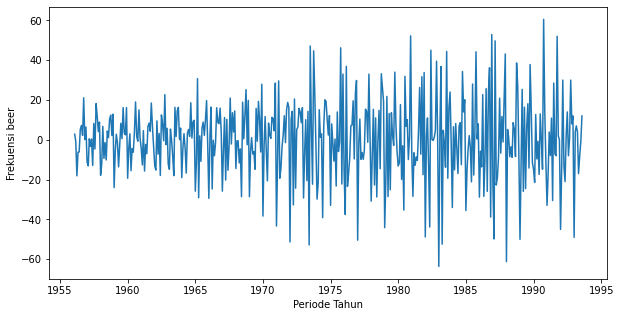

In [42]:
plt.figure(figsize=(10,5))
plt.xlabel('Periode Tahun')
plt.ylabel('Frekuensi beer')
plt.plot(stat_data['diferensiasi_pertama'])

#### menentukan nilai AR saama MA

C:\Users\giryi\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


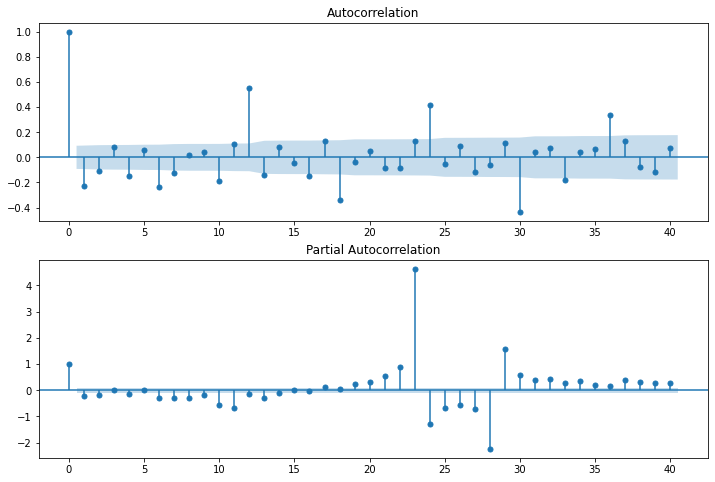

In [43]:
# Menentukan nilai AR (PACF) dan MA (ACF)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stat_data['diferensiasi_pertama'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stat_data['diferensiasi_pertama'].dropna(),lags=40,ax=ax2)

Model ARIMA = 2,1,2

In [44]:
model = ARIMA(train_data['Monthly beer production'],order=(2,1,2))
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\giryi\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\giryi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                 
=====================================================================================
Dep. Variable:     D.Monthly beer production   No. Observations:                  451
Model:                        ARIMA(2, 1, 2)   Log Likelihood               -1873.089
Method:                              css-mle   S.D. of innovations             15.221
Date:                       Sat, 08 Oct 2022   AIC                           3758.177
Time:                               21:37:18   BIC                           3782.846
Sample:                           02-01-1956   HQIC                          3767.899
                                - 08-01-1993                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.1572      0.134      1.169      0.242      -0.106       0.421
ar.L1.D.Monthly beer production     1.4057      0.035     40.367      0.000       1.337       1.474
ar.L2.D.Monthly beer production    -0.6705      0.035    -19.203      0.000      -0.739      -0.602
ma.L1.D.Monthly beer production    -1.9501      0.010   -191.175      0.000      -1.970      -1.930
ma.L2.D.Monthly beer production     0.9998      0.010     96.925      0.000       0.980       1.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0482           -0.6266j            1.2212           -0.0857
AR.2            1.0482           +0.6266j            1.2212            0.0857
MA.1            0.9752           -0.2218j            1.0001           -0.0356
MA.2            0.9752           +0.2218j            1.0001            0.0356
-----------------------------------------------------------------------------
"""

terlihat bahwa nilai p>z kurang dari 0.05 , jadi model ARIMA ini bisa di gunakan

C:\Users\giryi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


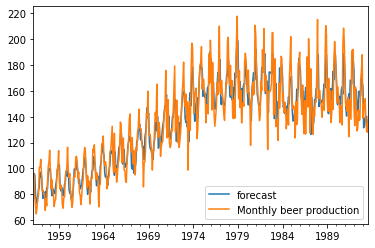

In [45]:
model_fit.plot_predict(dynamic=False)
plt.show()

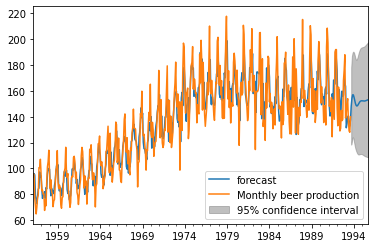

In [46]:
model_fit.plot_predict(1, len(train_data) + len(test_data), dynamic=False)
plt.show()

In [48]:
# Cek prediksi model dengan test data di 3 periode mendatang

fc, se, conf = model_fit.forecast(len(test_data), alpha=0.05) # 95% conf

# Membuat Series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

In [49]:
# nilia mapenya
mape = np.mean(np.abs(test_data['Monthly beer production'] - fc_series)/np.abs(fc_series))*100
mape

10.495454615609946

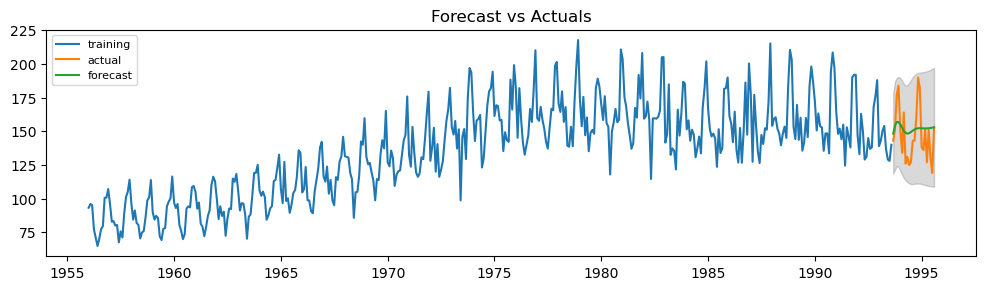

In [55]:
# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train_data["Monthly beer production"], label='training')
plt.plot(test_data["Monthly beer production"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()